In [134]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from openai import OpenAI
from tqdm import tqdm
import pickle
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Get the Counsel Chat Dataset

Extract 5 questions from each topic

In [51]:
dataset_name = "nbertagnolli/counsel-chat"
dataset = load_dataset(dataset_name, split="all")
dataset = dataset.shuffle(seed=42)

Repo card metadata block was not found. Setting CardData to empty.


In [52]:
dataset_df = dataset.to_pandas()
dataset_df.head()

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views
0,569,How do you get over someone cheating on you wh...,My boyfriend of five years told me he cheated ...,https://counselchat.com/questions/how-do-you-g...,intimacy,"Lynda MartensMarriage & Family Therapist, MSc,...",https://counselchat.com/therapists/ms-lynda-ma...,"Hi Michigan,This is a common issue. How do you...",2,130
1,787,Is it acceptable for me to find another home f...,My boyfriend moved in with me a few months ago...,https://counselchat.com/questions/is-it-accept...,relationships,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,Every living creature needs time and support t...,2,66
2,229,Am I somehow stressing myself out?,"I think I'm annoying and bothersome, but my gi...",https://counselchat.com/questions/am-i-somehow...,anxiety,"Lynda MartensMarriage & Family Therapist, MSc,...",https://counselchat.com/therapists/ms-lynda-ma...,"""Where you put your attention is where you wil...",2,271
3,933,How would I know if I have the right therapist?,How do you know you have the right therapist f...,https://counselchat.com/questions/how-would-i-...,counseling-fundamentals,"Jane M Floyd, PsyDOur life is shaped by our mi...",https://counselchat.com/therapists/jane-m-floy...,A therapist should be willing to have an initi...,0,29
4,929,Why can't I stop these thoughts?,I keep having these random thoughts that I don...,https://counselchat.com/questions/why-can-t-i-...,diagnosis,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,Those critical thoughts most likely came into...,0,740


In [53]:
dataset_df_filt = dataset_df[['topic', 'questionTitle', 'questionText', 'answerText', 'upvotes']].groupby('topic', group_keys=False).apply(lambda x: x.sort_values(['upvotes'], ascending=False)[:5]).reset_index(drop=True)
dataset_df_filt = dataset_df_filt.fillna('')
dataset_df_filt

/tmp/ipykernel_32086/731231056.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset_df_filt = dataset_df[['topic', 'questionTitle', 'questionText', 'answerText', 'upvotes']].groupby('topic', group_keys=False).apply(lambda x: x.sort_values(['upvotes'], ascending=False)[:5]).reset_index(drop=True)


,topic,questionTitle,questionText,answerText,upvotes
0,addiction,Is there a lawsuit for counselors and therapis...,I have a relative who is in his twenties. He w...,I'm so sorry to hear of your loss. This sound...,2
1,addiction,The organization I work for has told me I cann...,"This is my recovery, and I don't feel that it ...",You definitely want to make sure not to inadve...,2
2,addiction,How do I help my husband get over his drinking...,,Does your husband WANT to get over his drinkin...,1
3,addiction,The organization I work for has told me I cann...,"This is my recovery, and I don't feel that it ...","Hello, and thank you for your question. I know...",1
4,addiction,The organization I work for has told me I cann...,"This is my recovery, and I don't feel that it ...",I worked for an organization that had a simila...,0
...,...,...,...,...,...
144,workplace-relationships,Why do I feel like I'm always wrong in everyth...,My wife is always accusing me of cheating and ...,Hello. That must be very frustrating for you t...,9
145,workplace-relationships,How do I get over a coworker?,I've worked with this guy for about three year...,It sounds like you have mixed feelings and mot...,3
146,workplace-relationships,Why do I feel like I'm always wrong in everyth...,My wife is always accusing me of cheating and ...,Here is the truth: You will never get her to u...,2
147,workplace-relationships,I feel like I'm going to get fired because I c...,"I'm a teenager, and I just got my first job. I...","Getting your first job is an exciting, terrify...",2


### Use OpenAI to generate synthetic data

We need to generate a question pair from OpenAI by giving a relevant example from the CounselChat Dataset as one-shot instruction tuning.

In [54]:
with open("../../api.key", 'r') as file:
    openai_api_key = file.read()
    
openai_client = OpenAI(api_key=openai_api_key)

In [55]:
def get_openai_response(system_prompt: str, user_prompt: str) -> str:
    
    completion = openai_client.chat.completions.create(
    model="gpt-4o",
    temperature=1,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
        ]
    )

    openai_response = completion.choices[0].message.content
    
    return openai_response

In [ ]:
system_prompt_qa = 'You are an expert mental-health counsellor'
user_prompt_qa = '''You are given a broad topic which covers a specific area in which humans suffer from ill mental health.
You job is to generate a topic relevant question/answer pair with question describing the mental state of the patient and answer describing the counselling advice given to the patient.

Topic: {topic}

Example:
Question-> {question}
Answer-> {answer}

You must return response in a json serializable format as following {{question: question_text, answer:answer_text}}
'''

In [ ]:
# openai_responses_qa = []

# for index, row in tqdm(dataset_df_filt.iterrows(), total=len(dataset_df_filt)):
    
#     topic = row['topic']
#     question = row['questionText'] + row['questionTitle']
#     answer = row['answerText']
    
#     response_qa = get_openai_response(system_prompt=system_prompt_qa, user_prompt=user_prompt_qa.format(topic=topic, question=question, answer=answer))
    
#     openai_responses_qa.append(response_qa)

# with open('openai_responses_qa.pkl', 'wb') as file:
#     pickle.dump(openai_responses_qa, file)

### Reading the OpenAI Response files and converting to json for processing

In [ ]:
with open('openai_responses_qa.pkl', 'rb') as file:
    openai_responses_qa = pickle.load(file)

Converting to json responses

In [ ]:
json_responses = []
for index, response in enumerate(openai_responses_qa):
    response = response.replace('json','').replace("```","")
    try:
        json_responses.append(json.loads(response))
    except:
        print(index)
        json_responses.append(None)

3


Manually processing the ones with errors

In [ ]:
json_responses[3] = json.loads(openai_responses_qa[3].split("```")[1].replace('json',''))

In [61]:
dataset_df_topic_list = dataset_df_filt['topic'].to_list()

for index, topic in enumerate(dataset_df_topic_list):
    json_responses[index]['topic'] = topic

Adding the topics to each json response for later processing or analysis

In [62]:
json_responses

[{'question': "I've been struggling with alcohol addiction for years and recently I managed to stay sober for three months. However, I relapsed last week and I feel like I've failed completely. The shame and guilt are overwhelming, and I'm scared I won't be able to stay sober for long. How do I deal with these feelings and get back on track?",
  'answer': "First and foremost, it's important to acknowledge the progress you've already made and not dismiss it because of a setback. Relapse doesn't erase your hard work or mean you cannot succeed. It's a part of many people's recovery journey. Start by practicing self-compassion and forgiving yourself for the relapse. Reach out to your support system, whether that's friends, family, or a support group like Alcoholics Anonymous, and share your experience. Talking about it can lessen the burden of shame you're carrying. Reflect on the factors that might have contributed to your relapse and consider strategies to avoid or cope with them in the 

### Inference from already fine-tuned model

In [63]:
model_id = "llama32-sft-fine-tune-counselchat"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = "left"
tokenizer.model_max_length = 2048

In [64]:
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="auto") # Must be float32 for MacBooks!
model.config.pad_token_id = tokenizer.pad_token_id # Updating the model config to use the special pad token

Preparing a list of questions from GPT QA Responses for batch inference

In [68]:
llama_inputs = [[{"role": "user", "content": response['question']}] for response in json_responses]

texts = tokenizer.apply_chat_template(llama_inputs, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
inputs = {key: val.to(model.device) for key, val in inputs.items()}
temp_texts = tokenizer.batch_decode(inputs['input_ids'], skip_special_tokens=True)

In [69]:
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

In [ ]:
# gen_tokens = model.generate(
#     **inputs, 
#     max_new_tokens=2048, 
#     pad_token_id=tokenizer.pad_token_id, 
#     eos_token_id=terminators,
#     do_sample=True,
#     temperature=0.6,
#     top_p=0.9
# )

# gen_text = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)
# gen_text = [i[len(temp_texts[idx]):] for idx, i in enumerate(gen_text)]

# with open('llama_responses_qa.pkl', 'wb') as file:
#     pickle.dump(gen_text, file)

In [78]:
with open('llama_responses_qa.pkl', 'rb') as file:
    llama_response = pickle.load(file)

### Integrating the LLaMA Response within the json responses

In [81]:
for index, response in enumerate(llama_response):
    json_responses[index]['llama_answer'] = response

### Asking the GPT to rate the responses based on CTRS evaluations

In [82]:
json_responses

[{'question': "I've been struggling with alcohol addiction for years and recently I managed to stay sober for three months. However, I relapsed last week and I feel like I've failed completely. The shame and guilt are overwhelming, and I'm scared I won't be able to stay sober for long. How do I deal with these feelings and get back on track?",
  'answer': "First and foremost, it's important to acknowledge the progress you've already made and not dismiss it because of a setback. Relapse doesn't erase your hard work or mean you cannot succeed. It's a part of many people's recovery journey. Start by practicing self-compassion and forgiving yourself for the relapse. Reach out to your support system, whether that's friends, family, or a support group like Alcoholics Anonymous, and share your experience. Talking about it can lessen the burden of shame you're carrying. Reflect on the factors that might have contributed to your relapse and consider strategies to avoid or cope with them in the 

In [97]:
system_prompt_eval = 'You are an expert mental-health counsellor'
user_prompt_eval = '''You are given a conversation between a patient and therapist. Your job is to evaluate the response of therapist against the problem described by the patient as per the criterion of
Understanding, Interpersonal Effectiveness, Collaboration, Guided Discovery, Focus and Strategy. The definition for each of these criterion is mentioned below:

Understanding: How accurately does the therapist demonstrate understanding of the client’s issues and concerns?
Interpersonal Effectiveness: How effective is the therapist in maintaining a positive and therapeutic relationship with the client?
Collaboration: To what extent does the therapist engage the client in collaborative goalsetting and decision-making?
Guided Discovery: How effectively does the therapist use guided discovery techniques to facilitate client self-reflection and insight?
Focus: How well does the therapist identify and address the client’s key cognitions or behaviors that need change?
Strategy: How appropriate and coherent is the therapist’s strategy for promoting change in the client’s problematic behaviors or thoughts?

For each of these criterion, you need to assign a rating of 0 to 6 based on how well the therapist response fulfills the definition of the specific criterion.

You final response must not contain any description about any criterion and it must ONLY be in a json serializable format as following {{
    Understanding: understanding_rating,
    Interpersonal Effectiveness: interpersonal_effectiveness_rating,
    Collaboration: collaboration_rating,
    Guided Discovery: guided_discovery_rating,
    Focus: focus_rating,
    Strategy: strategy_rating,
}}

[PATIENT Problem]:
{patient}

[THERAPIST Response]:
{therapist}
'''

Evaluating the Responses of LLaMA

In [ ]:
# openai_responses_eval_llama = []

# for response in tqdm(json_responses):
    
#     patient_problem = response['question']
#     therapist_response = response['llama_answer'] #LLaMA Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     openai_responses_eval_llama.append(response_eval)

# with open('openai_responses_eval_llama.pkl', 'wb') as file:
#     pickle.dump(openai_responses_eval_llama, file)

100%|██████████| 149/149 [03:11<00:00,  1.28s/it]


In [105]:
with open('openai_responses_eval_llama.pkl', 'rb') as file:
    openai_responses_eval_llama = pickle.load(file)

Adding to Json Responses

In [112]:
for index, response in enumerate(openai_responses_eval_llama):
    response = response.replace('json','').replace("```",'')
    try:
        json_responses[index]['llama_answer_eval'] = json.loads(response)
    except:
        print(index)
        json_responses[index]['llama_answer_eval'] = None

Evaluating the Responses of GPT

In [106]:
# openai_responses_eval_gpt = []

# for response in tqdm(json_responses):
    
#     patient_problem = response['question']
#     therapist_response = response['answer'] #GPT Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     openai_responses_eval_gpt.append(response_eval)

# with open('openai_responses_eval_gpt.pkl', 'wb') as file:
#     pickle.dump(openai_responses_eval_gpt, file)

In [ ]:
with open('openai_responses_eval_gpt.pkl', 'rb') as file:
    openai_responses_eval_gpt = pickle.load(file)

In [114]:
for index, response in enumerate(openai_responses_eval_gpt):
    response = response.replace('json','').replace("```",'')
    try:
        json_responses[index]['gpt_answer_eval'] = json.loads(response)
    except:
        print(index)
        json_responses[index]['gpt_answer_eval'] = None

### Forming the visualizations using the evaluation criteria

In [122]:
topic_data = []
llama_undr = []
llama_intr_eff = []
llama_collab = []
llama_gd_disc = []
llama_foc = []
llama_strat = []
gpt_undr = []
gpt_intr_eff = []
gpt_collab = []
gpt_gd_disc = []
gpt_foc = []
gpt_strat = []

for response in tqdm(json_responses):
    topic_data.append(response['topic'])
    
    llama_undr.append(response['llama_answer_eval']['Understanding'])
    llama_intr_eff.append(response['llama_answer_eval']['Interpersonal Effectiveness'])
    llama_collab.append(response['llama_answer_eval']['Collaboration'])
    llama_gd_disc.append(response['llama_answer_eval']['Guided Discovery'])
    llama_foc.append(response['llama_answer_eval']['Focus'])
    llama_strat.append(response['llama_answer_eval']['Strategy'])
    
    gpt_undr.append(response['gpt_answer_eval']['Understanding'])
    gpt_intr_eff.append(response['gpt_answer_eval']['Interpersonal Effectiveness'])
    gpt_collab.append(response['gpt_answer_eval']['Collaboration'])
    gpt_gd_disc.append(response['gpt_answer_eval']['Guided Discovery'])
    gpt_foc.append(response['gpt_answer_eval']['Focus'])
    gpt_strat.append(response['gpt_answer_eval']['Strategy'])

100%|██████████| 149/149 [00:00<00:00, 172733.91it/s]


In [150]:
eval_df = pd.DataFrame({'llama_undr': llama_undr, 'gpt_undr': gpt_undr, 'llama_intr_eff': llama_intr_eff, 'gpt_intr_eff': gpt_intr_eff,
                        'llama_collab': llama_collab, 'gpt_collab': gpt_collab, 'llama_gd_disc': llama_gd_disc, 'gpt_gd_disc': gpt_gd_disc,
                        'llama_foc': llama_foc, 'gpt_foc': gpt_foc, 'llama_strat': llama_strat, 'gpt_strat': gpt_strat}, index=topic_data)

eval_df.head()

,llama_undr,gpt_undr,llama_intr_eff,gpt_intr_eff,llama_collab,gpt_collab,llama_gd_disc,gpt_gd_disc,llama_foc,gpt_foc,llama_strat,gpt_strat
addiction,4,5,5,5,3,4,2,4,2,5,3,5
addiction,4,5,3,5,2,4,2,4,4,5,3,5
addiction,3,5,3,6,2,4,1,4,2,5,2,5
addiction,3,5,4,5,1,4,1,4,2,5,2,5
addiction,3,5,3,5,1,4,1,3,2,5,2,5


In [151]:
avg_metrics = eval_df.agg('mean')
avg_metrics

llama_undr        3.758389
gpt_undr          5.127517
llama_intr_eff    3.825503
gpt_intr_eff      5.107383
llama_collab      2.174497
gpt_collab        3.543624
llama_gd_disc     1.845638
gpt_gd_disc       3.248322
llama_foc         2.812081
gpt_foc           4.395973
llama_strat       2.778523
gpt_strat         4.684564
dtype: float64

/tmp/ipykernel_32086/306645194.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


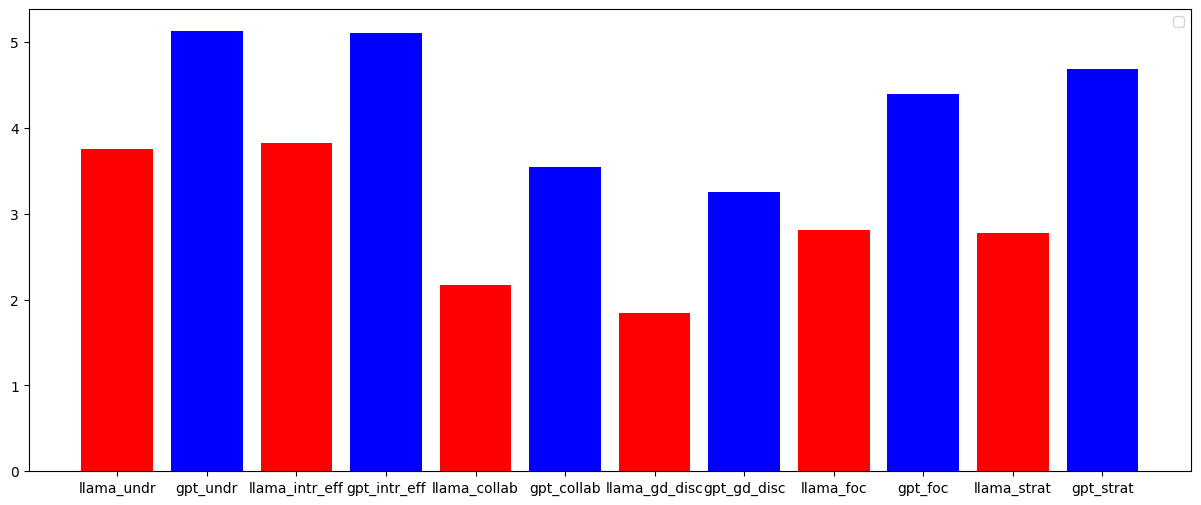

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(avg_metrics.index.to_list(), avg_metrics.values.tolist(), color=['r','b','r','b','r','b','r','b','r','b','r','b'])
plt.show()

In [164]:
topic_groupby_avg = eval_df.groupby(eval_df.index).mean()
topic_groupby_avg

,llama_undr,gpt_undr,llama_intr_eff,gpt_intr_eff,llama_collab,gpt_collab,llama_gd_disc,gpt_gd_disc,llama_foc,gpt_foc,llama_strat,gpt_strat
addiction,3.400000,5.0,3.6,5.2,1.800000,4.000000,1.4,3.800000,2.400000,5.0,2.4,5.000000
anger-management,3.600000,5.0,3.2,5.0,2.000000,3.400000,2.2,4.000000,3.000000,4.4,2.6,5.000000
anxiety,3.600000,5.0,3.2,5.2,1.800000,3.400000,1.6,2.800000,2.400000,4.2,2.6,4.800000
behavioral-change,4.200000,5.0,4.2,5.0,2.400000,3.600000,2.8,4.000000,3.200000,4.4,3.6,4.600000
children-adolescents,4.000000,5.4,4.2,5.0,2.200000,3.600000,1.8,3.000000,2.800000,4.6,2.8,4.800000
counseling-fundamentals,3.800000,5.0,4.2,5.4,2.400000,4.000000,2.2,3.400000,3.000000,4.4,3.0,4.800000
depression,3.000000,5.0,2.8,5.0,1.200000,3.400000,1.0,2.600000,2.000000,4.2,1.6,4.600000
diagnosis,3.000000,5.4,2.6,5.2,1.400000,3.600000,0.8,2.800000,1.800000,4.4,1.8,4.200000
domestic-violence,3.600000,5.4,4.0,5.2,2.400000,3.800000,1.4,3.600000,2.600000,5.0,3.2,4.800000
eating-disorders,3.400000,5.0,3.0,5.2,1.600000,3.000000,1.2,3.200000,2.000000,4.0,2.2,4.600000


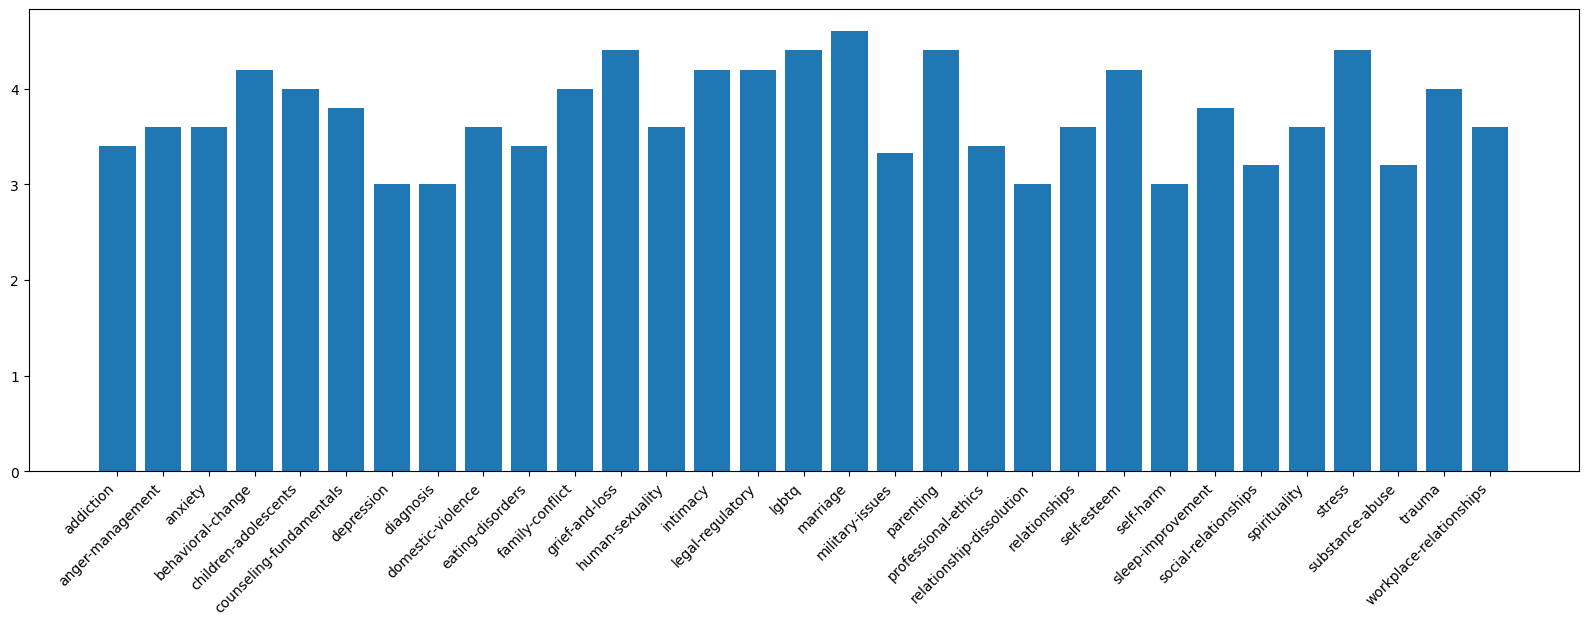

In [177]:
plt.figure(figsize=(20,6))
plt.bar(topic_groupby_avg.index.to_list(), topic_groupby_avg['llama_undr'].values.tolist())
plt.xticks(rotation=45, ha='right')
plt.show()